In [1]:
#general imports
import numpy as np
import pandas as pd


import unicodedata
import string
import re

#sklearn imports
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


#nltk imports
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import  SnowballStemmer

np.set_printoptions(linewidth=100)

sw = stopwords.words('english')
pt = string.punctuation
stemmer = SnowballStemmer('english')

## load data and drop image columns

In [2]:
df = pd.read_csv('skincare.csv')
df = df.reset_index(drop=True)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.drop(['Unnamed: 0.1'], axis=1, inplace=True);
df.head()

,Category,UserName,Product,UserReviewTitle,Url,Brand,ReviewText,Rank,OverallScore,Featured,UserRating,Date,ReviewTextMore,Image
0,More Anti-Aging,pynkNymphette,Elemis Pro-Collagen Marine Cream,$$$$$$,/reviews/product/503745/elemis-procollagen-mar...,Elemis Product Reviews,Crrrraaazzzyyyy expensive! But it works so gre...,1.0,9.3,1.0,8.0,"— 6 years, 2 months ago",NaN,http://images.totalbeauty.com/uploads/tx_userp...
1,More Anti-Aging,corina,Elemis Pro-Collagen Marine Cream,Elemis Pro Collagen Marine Cream,/reviews/product/503745/elemis-procollagen-mar...,Elemis Product Reviews,WOW . . . .this is a really good product. I fi...,2.0,9.3,0.0,10.0,"— 3 years, 11 months ago","people noticed, which is huge for me. I'm defi...",http://images.totalbeauty.com/uploads/tx_userp...
2,More Anti-Aging,Kathrina,Elemis Pro-Collagen Marine Cream,Good but pricey,/reviews/product/503745/elemis-procollagen-mar...,Elemis Product Reviews,I started using the Elemis line about 6 months...,3.0,9.3,0.0,10.0,"— 9 years, 2 months ago","ot recommend it for very dry skin though, it i...",http://images.totalbeauty.com/uploads/tx_userp...
3,More Anti-Aging,alicia_acedo,Elemis Pro-Collagen Marine Cream,Elemis Pro Collagen Marine Cream,/reviews/product/503745/elemis-procollagen-mar...,Elemis Product Reviews,"I had a complete facial, on a Carnival cruise ...",4.0,9.3,0.0,10.0,"— 3 years, 5 months ago",NaN,http://images.totalbeauty.com/uploads/tx_userp...
4,More Anti-Aging,sonia_silveroli,Elemis Pro-Collagen Marine Cream,Like Silk,/reviews/product/503745/elemis-procollagen-mar...,Elemis Product Reviews,"I purchased this a few years ago and WOW, just...",5.0,9.3,0.0,10.0,"— 5 years, 5 months ago",NaN,http://images.totalbeauty.com/uploads/tx_userp...


In [3]:
df.drop(['Image'], axis=1, inplace=True);

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60690 entries, 0 to 60689
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Category         60690 non-null  object 
 1   UserName         52032 non-null  object 
 2   Product          60690 non-null  object 
 3   UserReviewTitle  52032 non-null  object 
 4   Url              60690 non-null  object 
 5   Brand            60690 non-null  object 
 6   ReviewText       52031 non-null  object 
 7   Rank             52032 non-null  float64
 8   OverallScore     52032 non-null  float64
 9   Featured         52032 non-null  float64
 10  UserRating       52032 non-null  float64
 11  Date             52032 non-null  object 
 12  ReviewTextMore   7965 non-null   object 
dtypes: float64(4), object(9)
memory usage: 6.0+ MB


In [5]:
df.Category.nunique()

22

In [6]:
#reduce datafame for ease of use
skindf = df.drop(['UserReviewTitle', 'Url', 'ReviewTextMore'], axis=1);
skindf.head()

,Category,UserName,Product,Brand,ReviewText,Rank,OverallScore,Featured,UserRating,Date
0,More Anti-Aging,pynkNymphette,Elemis Pro-Collagen Marine Cream,Elemis Product Reviews,Crrrraaazzzyyyy expensive! But it works so gre...,1.0,9.3,1.0,8.0,"— 6 years, 2 months ago"
1,More Anti-Aging,corina,Elemis Pro-Collagen Marine Cream,Elemis Product Reviews,WOW . . . .this is a really good product. I fi...,2.0,9.3,0.0,10.0,"— 3 years, 11 months ago"
2,More Anti-Aging,Kathrina,Elemis Pro-Collagen Marine Cream,Elemis Product Reviews,I started using the Elemis line about 6 months...,3.0,9.3,0.0,10.0,"— 9 years, 2 months ago"
3,More Anti-Aging,alicia_acedo,Elemis Pro-Collagen Marine Cream,Elemis Product Reviews,"I had a complete facial, on a Carnival cruise ...",4.0,9.3,0.0,10.0,"— 3 years, 5 months ago"
4,More Anti-Aging,sonia_silveroli,Elemis Pro-Collagen Marine Cream,Elemis Product Reviews,"I purchased this a few years ago and WOW, just...",5.0,9.3,0.0,10.0,"— 5 years, 5 months ago"


## Original Dataframe EDA & Basic Metrics

In [7]:
#how many unique products & unique users
users_count = df['UserName'].nunique()
products_count = df['Product'].nunique();
category_count = df['Category'].nunique();
print(f'Total number of users: {users_count}.  Total number of products: {products_count}.  Total number of categories: {category_count}')

Total number of users: 24071.  Total number of products: 14854.  Total number of categories: 22


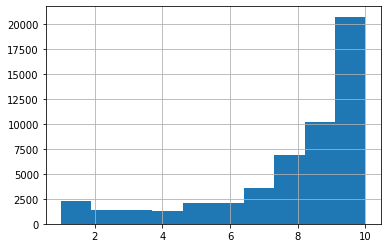

In [8]:
#histogram of user ratings
df['UserRating'].hist();

In [9]:
category = df.Category.value_counts()
category

More Moisturizer                       12034
More Cleanser                          10950
More Anti-Aging                         7014
More Eye Treatments                     4190
More Blemish + Acne Control             3923
More Masks, Peels                       3083
More Exfoliators, Scrubs                3055
More Makeup Remover                     2625
More Toners, Astringents                2219
More Night Cream                        2085
More Sun Protection                     1552
More Self Tanners                       1324
More Tools + Appliances                 1319
More Toothpaste + Breath Freshener      1262
More Lip Plumper                         956
More Oral Care                           649
More Dermatology Treatments & Peels      631
More Lightening Cream                    610
More Ingestibles + Supplements           513
More Microdermabrasion                   410
More Lip Exfoliant                       284
More                                       2
Name: Cate

## Make skincare dataframe for reduced scope

In [10]:
#make skincare dataframe for more specific recommender

In [11]:
skindf = df.query('Category == ["More Moisturizer","More Cleanser","More Anti-Aging","More Eye Treatments","More Blemish + Acne Control","More Masks, Peels, More Exfoliators, Scrubs","More Toners, Astringents","More Night Cream","More Sun Protection"]')
skindf.info()
#for now leave in unrated products

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43967 entries, 0 to 60689
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Category         43967 non-null  object 
 1   UserName         37760 non-null  object 
 2   Product          43967 non-null  object 
 3   UserReviewTitle  37760 non-null  object 
 4   Url              43967 non-null  object 
 5   Brand            43967 non-null  object 
 6   ReviewText       37760 non-null  object 
 7   Rank             37760 non-null  float64
 8   OverallScore     37760 non-null  float64
 9   Featured         37760 non-null  float64
 10  UserRating       37760 non-null  float64
 11  Date             37760 non-null  object 
 12  ReviewTextMore   5922 non-null   object 
dtypes: float64(4), object(9)
memory usage: 4.7+ MB


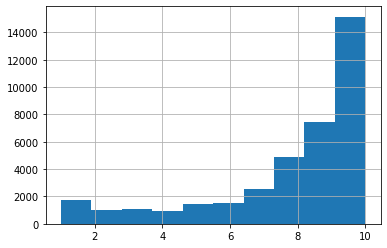

In [12]:
#histogram of user ratings
skindf['UserRating'].hist();

In [13]:
category_list = ["More Moisturizer","More Cleanser","More Anti-Aging","More Eye Treatments","More Blemish + Acne Control","More Masks, Peels, More Exfoliators, Scrubs","More Toners, Astringents","More Night Cream","More Sun Protection"]

In [14]:
skindf.Category.value_counts()

More Moisturizer               12034
More Cleanser                  10950
More Anti-Aging                 7014
More Eye Treatments             4190
More Blemish + Acne Control     3923
More Toners, Astringents        2219
More Night Cream                2085
More Sun Protection             1552
Name: Category, dtype: int64

In [15]:
#skindf.iloc[:4, 1]
#skindf.loc[:,'Category']

In [16]:
skindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43967 entries, 0 to 60689
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Category         43967 non-null  object 
 1   UserName         37760 non-null  object 
 2   Product          43967 non-null  object 
 3   UserReviewTitle  37760 non-null  object 
 4   Url              43967 non-null  object 
 5   Brand            43967 non-null  object 
 6   ReviewText       37760 non-null  object 
 7   Rank             37760 non-null  float64
 8   OverallScore     37760 non-null  float64
 9   Featured         37760 non-null  float64
 10  UserRating       37760 non-null  float64
 11  Date             37760 non-null  object 
 12  ReviewTextMore   5922 non-null   object 
dtypes: float64(4), object(9)
memory usage: 4.7+ MB


In [17]:
skindf = skindf[skindf['UserName'].notnull()]
skindf.drop(['ReviewTextMore'], axis=1, inplace=True)
skindf.drop(['Url'], axis=1, inplace=True);
skindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37760 entries, 0 to 51988
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Category         37760 non-null  object 
 1   UserName         37760 non-null  object 
 2   Product          37760 non-null  object 
 3   UserReviewTitle  37760 non-null  object 
 4   Brand            37760 non-null  object 
 5   ReviewText       37760 non-null  object 
 6   Rank             37760 non-null  float64
 7   OverallScore     37760 non-null  float64
 8   Featured         37760 non-null  float64
 9   UserRating       37760 non-null  float64
 10  Date             37760 non-null  object 
dtypes: float64(4), object(7)
memory usage: 3.5+ MB


## Item - Item Recommender

In [18]:
itemitem = skindf.drop(['Category', 'UserReviewTitle', 'Brand', 'ReviewText', 'Rank','OverallScore', 'Featured', 'Date'], axis=1);
itemitem.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37760 entries, 0 to 51988
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   UserName    37760 non-null  object 
 1   Product     37760 non-null  object 
 2   UserRating  37760 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.2+ MB


In [19]:
#shuffle rows and return all rows
itemitem.sample(frac=1)

,UserName,Product,UserRating
44731,Kate8817,Zapzyt 10% Benzoyl Peroxide Acne Treatment Gel,1.0
10472,amazinggrace15,Nu Skin AgeLoc Future Serum,10.0
33338,Elise0007,N.V. Perricone Pore Refining Toner Pads (Acne ...,2.0
12608,strawberrysnafu,Phisoderm Clarifying Gel Facial Moisturizer,9.0
10462,ambreprn,Philosophy Purity Made Simple Foaming 3-in-1 C...,10.0
...,...,...,...
46870,caitlin_bickel,Simple Facial Exfoliating Wipes,3.0
13847,ann_lavine,Clinique Rinse-Off Foaming Cleanser,5.0
17479,annsw13,Olay Foaming Face Wash for Sensitive Skin,9.0
6218,kimmi_o,Crabtree & Evelyn Skin Care Routine Balancing ...,10.0


In [20]:
itemitem.UserName.nunique(), itemitem.Product.nunique()

(19396, 4621)

In [21]:
itemitem.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37760 entries, 0 to 51988
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   UserName    37760 non-null  object 
 1   Product     37760 non-null  object 
 2   UserRating  37760 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.2+ MB


In [22]:
import random
import numpy as np

from surprise import SVD
from surprise import Dataset
from surprise import NormalPredictor
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from surprise.model_selection import KFold


my_seed = 19
random.seed(my_seed)
np.random.seed(my_seed)

In [23]:

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 10))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(itemitem[['UserName', 'Product', 'UserRating']], reader)

# We can now use this dataset as we please, e.g. calling cross_validate
cross_validate(NormalPredictor(), data, cv=2)

{'test_rmse': array([3.32805636, 3.35696252]),
 'test_mae': array([2.53694065, 2.54907936]),
 'fit_time': (0.03272509574890137, 0.03551888465881348),
 'test_time': (0.26746702194213867, 0.16671323776245117)}

In [24]:
# define a cross-validation iterator
kf = KFold(n_splits=3)

algo = SVD()

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 2.3794
RMSE: 2.3537
RMSE: 2.3902


In [25]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import GridSearchCV


param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

2.4005266917929795
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


In [26]:
algo = gs.best_estimator['rmse']


In [27]:
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')

Number of users:  14493 

Number of items:  3987 



In [28]:
from collections import defaultdict

from surprise import SVD
from surprise import Dataset


def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# First train an SVD algorithm on the movielens dataset.
trainset = data.build_full_trainset()
algo = gs.best_estimator['rmse']
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)



In [29]:
top_n = get_top_n(predictions, n=10)

# # Print the recommended items for each user
# for uid, user_ratings in top_n.items():
#     print(uid, [iid for (iid, _) in user_ratings])

In [30]:
[print(v) for i, v in enumerate(top_n.items()) if i < 5]

('pynkNymphette', [('Nu Skin AgeLoc Future Serum', 8.95521667171845), ('DHC Deep Cleansing Oil', 8.72568371609157), ('Vine Vera Resveratrol Chianti Overnight Recovery', 8.63161872319324), ('Mary Kay After-Sun Replenishing Gel', 8.628289805739852), ('Pristine Beauty Hooray for Brallywood Butta Luxe Intensive Facial Creme', 8.592297666142509), ('Elanveda Skin Renue', 8.546768016611301), ('Suki Exfoliate Foaming Cleanser', 8.535734493954092), ('Principal Secret Reclaim Total Facial Cleanser', 8.534346980216975), ('Olay Active Hydrating Beauty Fluid Lotion - Original', 8.533191308469311), ('Revive Sensitif Cellular Repair Cream', 8.533065414000164)])
('corina', [('Nu Skin AgeLoc Future Serum', 9.072914186623862), ('M.A.C. Mineralize Charged Water: Revitalizing Energy', 8.912455773045945), ('DHC Deep Cleansing Oil', 8.80643795940901), ('Vine Vera Resveratrol Chianti Overnight Recovery', 8.727029769294314), ('Elanveda Skin Renue', 8.701577980562668), ('Suki Exfoliate Foaming Cleanser', 8.693

[None, None, None, None, None]

In [31]:
print(len(predictions))

89591266


In [32]:
# import random                                                              
                                                                                                                   
                                                                           
# # Load your full dataset.                                                  
# # A reader is still needed but only the rating_scale param is requiered.
# reader = Reader(rating_scale=(1, 10))

# # The columns must correspond to user id, item id and ratings (in that order).
# data = Dataset.load_from_df(itemitem[['UserName', 'Product', 'UserRating']], reader)  


# raw_ratings = data.raw_ratings                                             
                                                                           
# # shuffle ratings if you want                                              
# random.shuffle(raw_ratings)                                                
                                                                           
# # 80% trainset, 20% testset                                                
# threshold = int(.8 * len(raw_ratings))                                     
# trainset_raw_ratings = raw_ratings[:threshold]                             
# test_raw_ratings = raw_ratings[threshold:]                                 
                                                                           
# data.raw_ratings = trainset_raw_ratings  # data is now your trainset       
# data.split(n_folds=3)                                                      
                                                                           
# # Select your best algo with grid search. Verbosity is buggy, I'll fix it. 
# print('GRID SEARCH...')                                                    
# param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005]}               
# grid_search = GridSearch(SVD, param_grid, measures=['RMSE'], verbose=0)    
# grid_search.evaluate(data)                                                 
                                                                           
# algo = grid_search.best_estimator['RMSE']                                  
                                                                           
# # retrain on the whole train set                                           
# trainset = data.build_full_trainset()                                      
# algo.train(trainset)                                                       
                                                                           
# # now test on the trainset                                                 
# testset = data.construct_testset(trainset_raw_ratings)                     
# predictions = algo.test(testset)                                           
# print('Accuracy on the trainset:')                                         
# accuracy.rmse(predictions) 